# EDA for the Blog os Vinhos data and rating prediction

# Exploratory Analysis, Clustering, and Prediction of Subjective Wine Ratings

This notebook explores a dataset of Portuguese wines rated by expert judges.  
The target variable is a **subjective quality score**, not an objective chemical or sensory measurement.

## Dataset overview
Available information includes:
- Alcohol percentage  
- Year of production  
- Minimum and maximum price  
- Grape varieties, region, and color  

No chemical composition or laboratory measurements are available.

## Objective
The goal of this analysis is **not** to build a high-accuracy wine quality predictor.  
Instead, the notebook investigates:

- Which types of features carry meaningful signal in subjective ratings  
- Whether adding categorical descriptors (grapes, region) improves or degrades analysis  
- How clustering and prediction behave when the target is perception-based  

## Approach
The analysis proceeds in three steps:
1. Exploratory data analysis and preprocessing  
2. Clustering using different feature subsets (numerical, categorical, mixed)  
3. Predictive modeling and explainability to assess feature contribution  

## Key question
Does adding more descriptive information necessarily lead to better insights, or can it introduce noise when the underlying signal is weak or subjective?


----

# Libraries Import

In [2]:
#Let's ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Libraries import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from collections import Counter

import re
import unicodedata

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import shap


# Data Loading

In [3]:
#Reading our dataset
df = pd.read_csv('..\\data\\raw\\PortugueseWines.csv')
df.head(3)

,Unnamed: 0,Name,Region,Year,Color,Castes,AlcoholPercentage,Producer,MinimunPrice,MaximumPrice,Judge,JudgeRating,Date,JudgeNotes,Label,Link
0,0,.Beb,Regional Alentejo,2007,Rosé,"Cabernet Sauvignon, Syrah e Touriga Nacional",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço,15.5,Dezembro 2008,Cor vermelha brilhante e aromas iniciais domin...,Tem uma cor atraente e um aroma intenso a frut...,https://osvinhos.blogspot.pt/2010/03/1232-beb-...
1,1,.Beb,Regional Alentejo,2009,Red,"Cabernet Sauvignon, Syrah, Alicante Bouschet e...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Susana Esteban,16.0,Novembro 2012,"Cor avermelhada e nariz muito aromático, onde ...",A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2013/08/2803-beb-...
2,2,.Beb,Regional Alentejo,2010,Red,"Cabernet Sauvignon, Syrah, Alicante Bouschet e...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço,16.0,Agosto 2013,Apresenta uma cor rubi agradavelmente concentr...,A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2014/01/2988-beb-...


In [4]:
df.describe()

,Unnamed: 0,Year,AlcoholPercentage,MinimunPrice,MaximumPrice,JudgeRating
count,2993.000000,2993.000000,2993.000000,2993.000000,2993.000000,2993.000000
mean,1496.000000,2000.924156,13.405112,9.657701,14.688573,15.639492
std,864.149003,127.122885,0.939524,8.548043,40.881400,1.130448
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,748.000000,2005.000000,13.000000,4.000000,7.500000,15.000000
50%,1496.000000,2009.000000,13.500000,7.500000,10.000000,15.500000
75%,2244.000000,2013.000000,14.000000,12.500000,15.000000,16.500000
max,2992.000000,2018.000000,17.000000,155.000000,2150.000000,19.000000


In [5]:
#Let's see if we have missing values
df.isnull().values.any()

np.True_

In [6]:
#Let's see if we have missing values - 2 
df.isna().sum()

Unnamed: 0            0
Name                  0
Region                4
Year                  0
Color                 0
Castes                4
AlcoholPercentage     0
Producer              0
MinimunPrice          0
MaximumPrice          0
Judge                 0
JudgeRating           0
Date                 23
JudgeNotes            1
Label                 1
Link                  0
dtype: int64

So we have 4 entries with missing region, 4 with missing grapes' type - these two are sad, we can use this features in the analysis
We also don't have 23 dates missing - it's not critical and 1 Lable missing - also nothing too bad.

_____________________________________________________

In this project some features were excluded for simplification reasons - we got rid of Judge, JudgeNotes, Labels and Link. First 3 of those may be used for NLP or text analytics, but it's not the focus of this little project

In [7]:
#For easier representation
#'Name', 'Region'' are better to be categorical and 
#'Year' (we will switch it to Age),'AlcoholPercentage','MinimunPrice','MaximumPrice' - float. 
cols = ['Name','Region']
for col in cols:
    df[col] = pd.Categorical(df[col])
cols = ['Year','AlcoholPercentage','MinimunPrice','MaximumPrice','JudgeRating']
for col in cols:
    df[col] = df[col].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2993 entries, 0 to 2992
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Unnamed: 0         2993 non-null   int64   
 1   Name               2993 non-null   category
 2   Region             2989 non-null   category
 3   Year               2993 non-null   float64 
 4   Color              2993 non-null   object  
 5   Castes             2989 non-null   object  
 6   AlcoholPercentage  2993 non-null   float64 
 7   Producer           2993 non-null   object  
 8   MinimunPrice       2993 non-null   float64 
 9   MaximumPrice       2993 non-null   float64 
 10  Judge              2993 non-null   object  
 11  JudgeRating        2993 non-null   float64 
 12  Date               2970 non-null   object  
 13  JudgeNotes         2992 non-null   object  
 14  Label              2992 non-null   object  
 15  Link               2993 non-null   object  
dtypes: cat

In [8]:
#let's transform Year into age of wine
from datetime import datetime
current_year = datetime.now().year
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Age"] = current_year - df["Year"]
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

df = df[(df["Age"] >= 0) & (df["Age"] <= 100)]

In [9]:
#It will be interesting to look at numerical data. 
data = df[['Age','AlcoholPercentage','MinimunPrice','MaximumPrice','JudgeRating','Color']]

In [10]:
data['MinimunPrice'].value_counts()

MinimunPrice
 4.0      697
 7.5      690
 10.0     373
 2.0      317
 12.5     271
 15.0     269
 25.0     165
 20.0     151
 50.0      22
-1.0       16
 75.0       6
 100.0      3
 155.0      1
Name: count, dtype: int64

In [11]:
data['MaximumPrice'].value_counts()

MaximumPrice
 7.5       696
 10.0      690
 12.5      373
 4.0       317
 20.0      270
 15.0      270
 50.0      166
 25.0      151
 75.0       22
 2.0        16
 100.0       5
-1.0         3
 2150.0      1
 7.4         1
Name: count, dtype: int64

In [12]:
data['Age'].value_counts()

Age
19.0    239
18.0    229
15.0    228
21.0    226
17.0    225
13.0    202
16.0    199
14.0    194
22.0    190
12.0    185
11.0    166
20.0    156
23.0    139
10.0    125
9.0      74
25.0     63
24.0     56
26.0     27
27.0     24
8.0      15
29.0      4
30.0      2
31.0      2
41.0      2
32.0      1
28.0      1
61.0      1
51.0      1
40.0      1
36.0      1
35.0      1
59.0      1
38.0      1
Name: count, dtype: int64

In [13]:
data['JudgeRating'].value_counts()

JudgeRating
 15.5    725
 16.0    712
 16.5    430
 15.0    347
 17.0    257
 14.5    207
 14.0     97
 13.5     69
 17.5     61
 13.0     34
 12.5     13
 18.0     13
 12.0      6
 0.0       3
 11.5      3
 18.5      1
 19.0      1
-1.0       1
 8.0       1
Name: count, dtype: int64

In [14]:
# For further analysis let's remove outliers
data = data[(data['MaximumPrice']<2000) & (data['MaximumPrice']>0)]
data = data[data['Age']>0]
data = data[data['JudgeRating']>0]

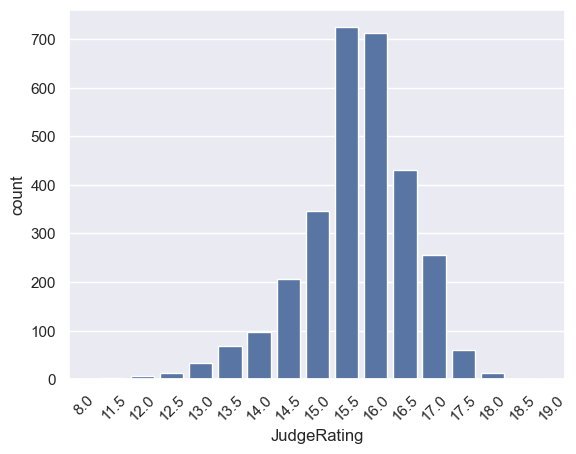

In [15]:
#Let's take a look at JudgeRating distribution
sns.countplot(x="JudgeRating",data=data)
plt.xticks(rotation=45)
plt.show()

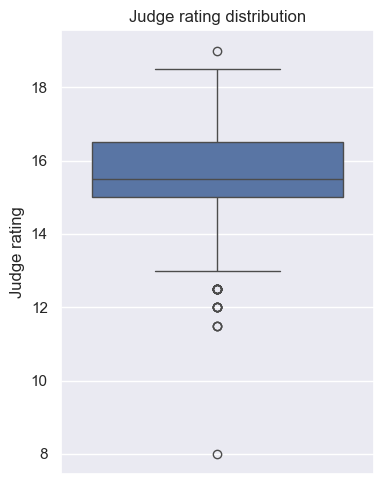

In [16]:
plt.figure(figsize=(4, 5))
sns.boxplot(y="JudgeRating", data=data)
plt.title("Judge rating distribution")
plt.ylabel("Judge rating")
plt.tight_layout()
plt.show()


As we can see, most of the wines have JudgeRating between 14.5 and 17. Is it connected to the type of wine? 

<Axes: xlabel='JudgeRating', ylabel='Density'>

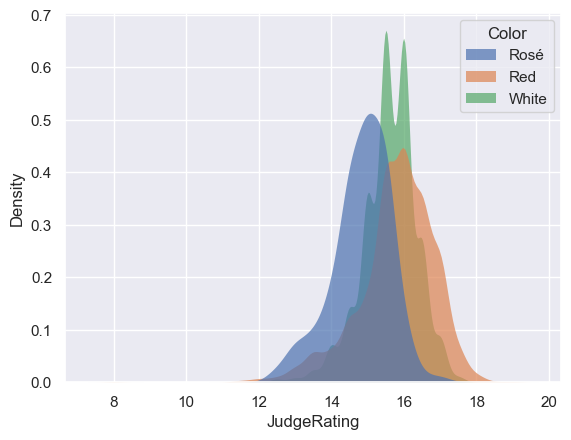

In [17]:
sns.kdeplot(data, x="JudgeRating", hue="Color",fill=True, common_norm=False, 
   alpha=.7, linewidth=0)

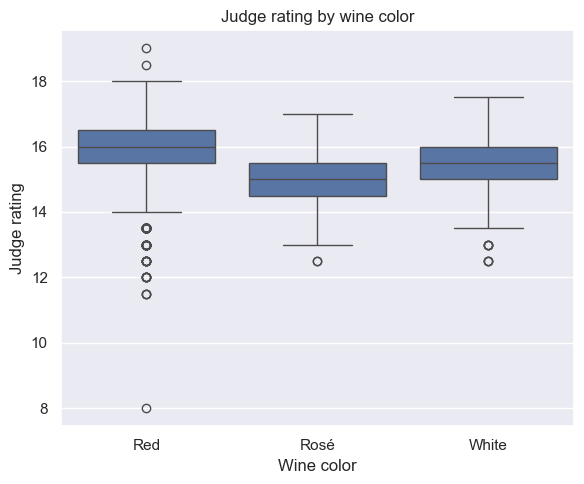

In [18]:
plt.figure(figsize=(6, 5))
sns.boxplot(
    x="Color",
    y="JudgeRating",
    data=data,
    order=["Red", "Rosé", "White"]
)
plt.title("Judge rating by wine color")
plt.xlabel("Wine color")
plt.ylabel("Judge rating")
plt.tight_layout()
plt.show()


All the rating marks are between 8 and 18, with the most marks being around 15-16. The difference between wine type is also not too drastic as we can see

Now let's see a pairplot

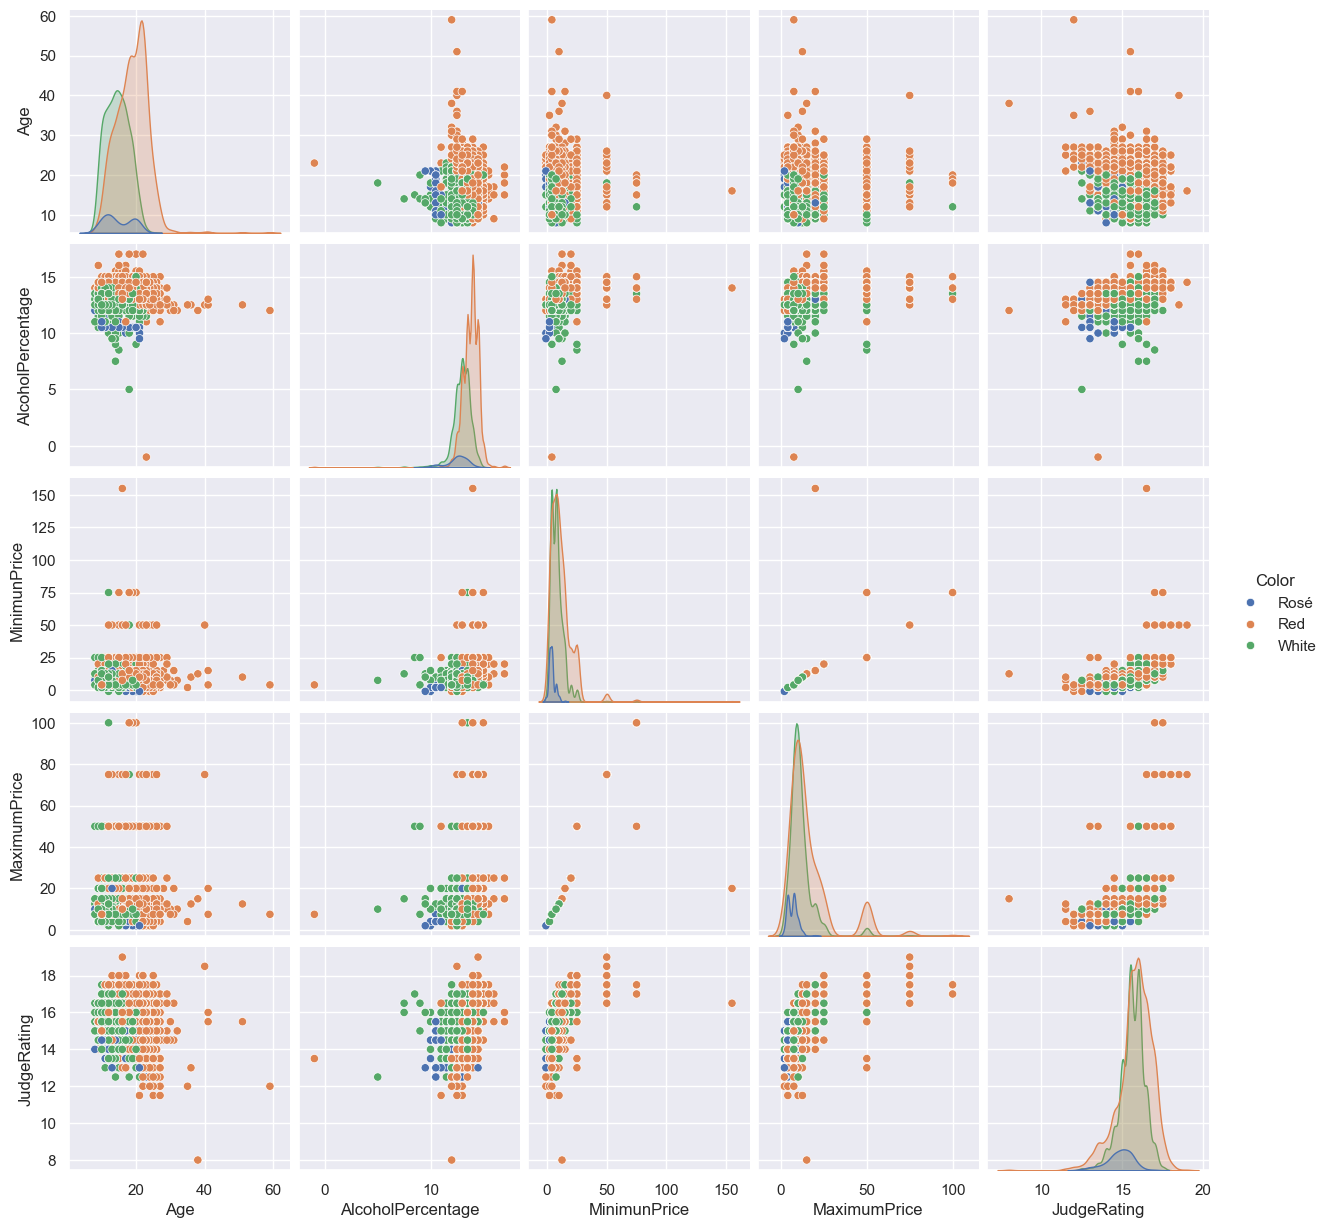

In [19]:
sns.pairplot(data,hue = 'Color')
plt.show()

There is no visible connections... So let's see the correlation matrix for numerical values

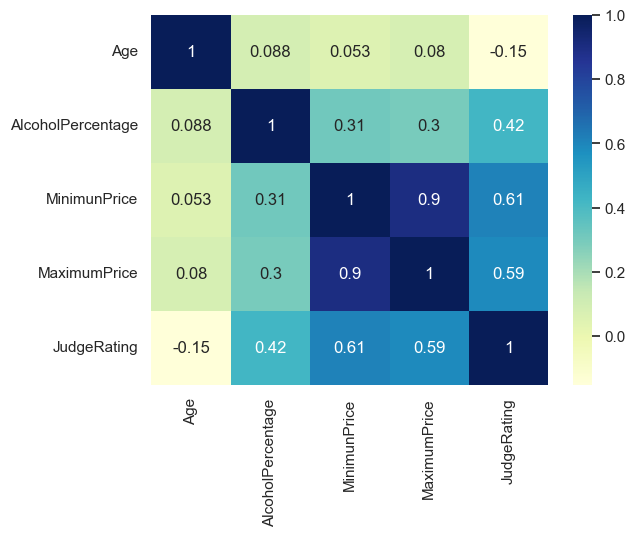

In [20]:
#Let's create a correlation matrix for numerical values and see 
#what is Rating mostly influenced by
dataplot = sns.heatmap(data[['Age','AlcoholPercentage','MinimunPrice','MaximumPrice','JudgeRating']].corr(), cmap="YlGnBu", annot=True)
#Don't incluse 'Color' as it's not numerical

So, the connection of rating is with Min and Max Price and Alcohol % is pretty strong as well as correlation between Min and Max prices. It may make sence to take an average between Max and min to reduce the number of features in the future. Age however is not heavily correlated with anything

Let's take a look at charts

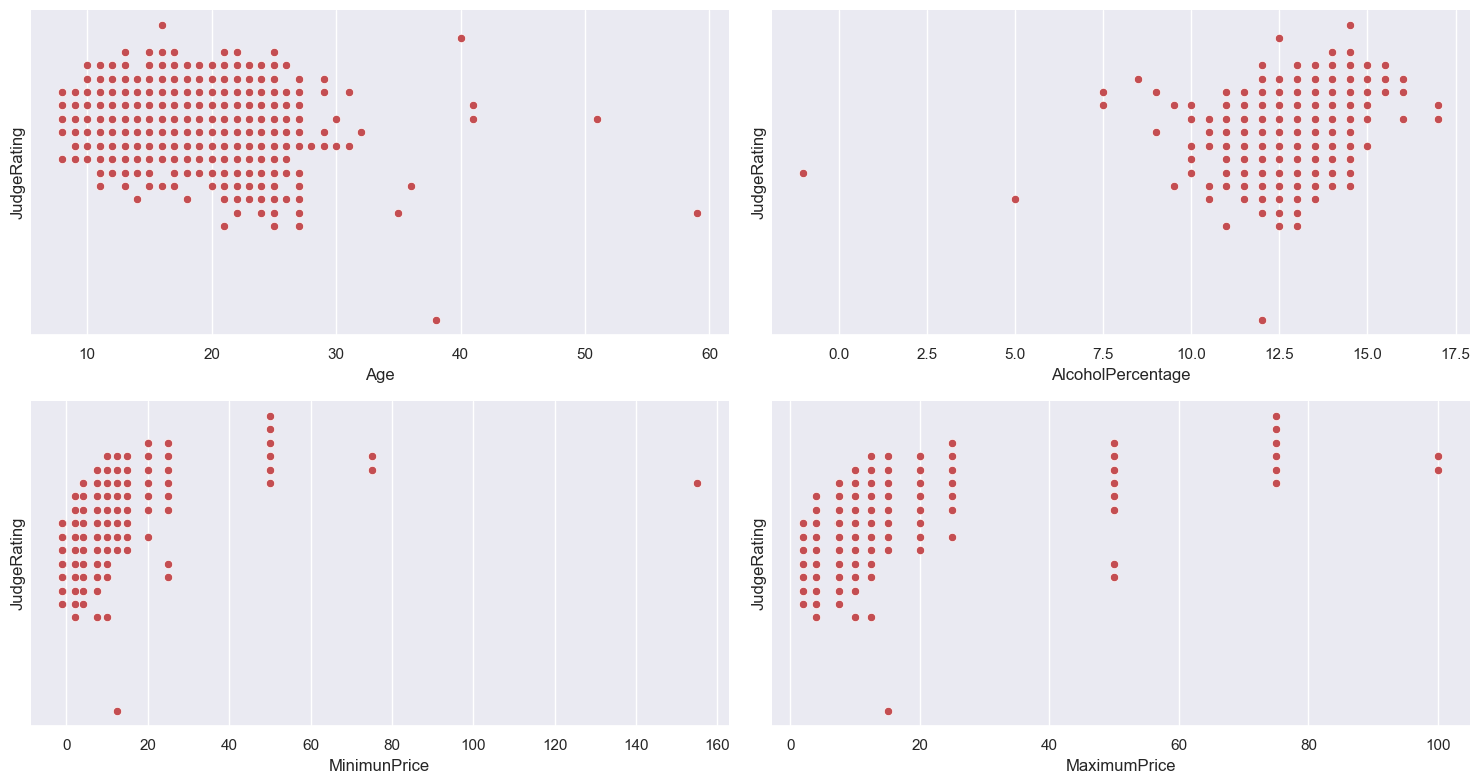

In [21]:
f, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.despine(left=True)

#Plot a histogram and kernel density estimate
cols = ['Age','AlcoholPercentage','MinimunPrice','MaximumPrice']

i = 0
for col in cols: 
    
    sns.scatterplot(x = cols[i], y = 'JudgeRating', data = data, color="r",ax=axes[i//2,i%2])
    i += 1

plt.setp(axes, yticks=[])
plt.tight_layout()

______________________________________________________

## Grapes

Let's create new features based on the grapes' types from the Castes column. It will be the grape type the wine was made from. We will hot encode them for future usage

In [22]:
def normalize_castes_string(s):
    if pd.isna(s):
        return ""

    # to string
    s = str(s)

    # lowercase
    s = s.lower()

    # normalize accents
    s = "".join(
        ch for ch in unicodedata.normalize("NFKD", s)
        if not unicodedata.combining(ch)
    )

    # fix punctuation / spacing
    s = s.replace("’", "'")
    s = re.sub(r"\s*,\s*", ",", s)   # spaces around commas
    s = re.sub(r",+", ",", s)        # multiple commas
    s = re.sub(r"\s+", " ", s)       # multiple spaces
    s = s.strip(" ,")

    return s

df["Castes_norm"] = df["Castes"].apply(normalize_castes_string)

In [23]:
#Now we need to fix spelling, typos etc
FIX = {
    "alicate bouschet": "alicante bouschet",
    "cbernet franc": "cabernet franc",
    "touriga nacioal": "touriga nacional",
    "chaardonnay": "chardonnay",
    "viogner": "viognier",
}

def apply_fixes(s):
    if not s:
        return s
    parts = s.split(",")
    parts = [FIX.get(p, p) for p in parts]
    return ",".join(parts)

df["Castes_norm"] = df["Castes_norm"].apply(apply_fixes)

In [24]:
#hot encode the grape varieties
castes_ohe = df["Castes_norm"].str.get_dummies(sep=",")
castes_ohe = castes_ohe.drop(columns=["-"], errors="ignore")
df = pd.concat([df, castes_ohe], axis=1)
castes_ohe.head()

,alfrocheiro,alfrocheiro e alicante bouschet,alfrocheiro e aragonez,alfrocheiro e cabernet sauvignon,alfrocheiro e jaen,alfrocheiro e rufete,alfrocheiro e syrah,alfrocheiro e tinta roriz,alfrocheiro e touriga nacional,alfrocheiro e trincadeira,...,viosinho e viognier,viozinho,vital e vinhas velhas,viura,welschriesling e chardonnay,xarello,xarello e parellada,zeta,zinfandel,zinfandel e petit syrah
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


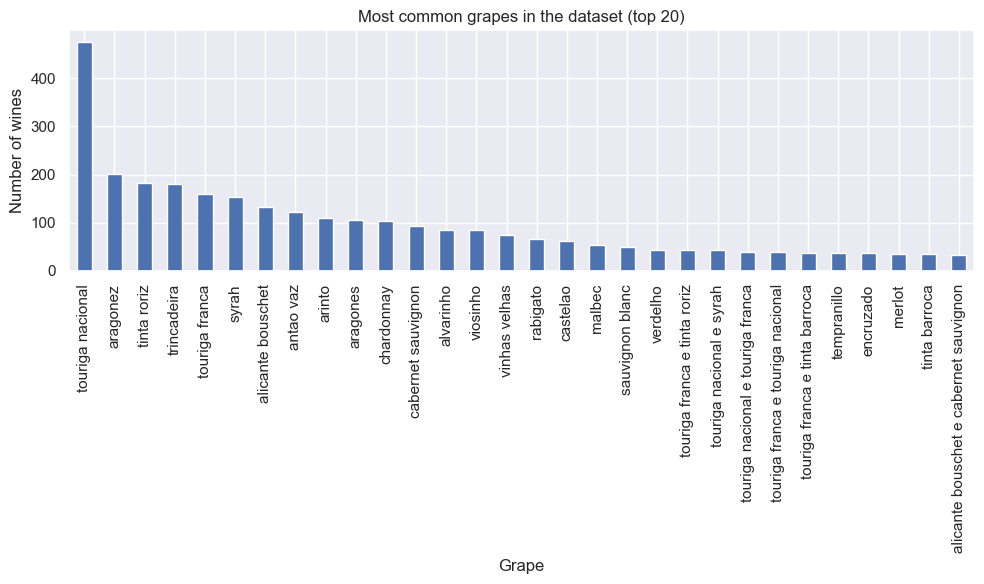

In [25]:
grape_counts = castes_ohe.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
grape_counts.head(30).plot(kind="bar")
plt.title("Most common grapes in the dataset (top 20)")
plt.ylabel("Number of wines")
plt.xlabel("Grape")
plt.tight_layout()
plt.show()

-------------------------------------------------------

## Region and Producer

In [26]:
df.Region.unique()

['Regional Alentejo', 'Regional Tejo', 'DOC Douro', 'Regional Vinhos Verdes', 'Argentina', ..., 'DOC Vinhos Verdes / Douro', 'DOC Algarve', 'DOC Rioja (Espanha)', 'Brasil', 'França (Saint-Emilion)']
Length: 58
Categories (59, object): ['Alemanha', 'Argentina', 'Austrália', 'Brasil', ..., 'Tunísia', 'Uruguai', 'África do Sul', 'Áustria']

In [27]:
df.Region.value_counts()

Region
Regional Alentejo                687
DOC Douro                        616
DOC Alentejo                     211
Regional Península de Setúbal    176
Espanha                          153
DOC Dão                          128
DOC Vinhos Verdes                 99
Argentina                         95
França                            92
Regional Lisboa                   75
Regional Tejo                     53
DOC Bairrada                      50
Chile                             49
Regional Algarve                  46
Regional Ribatejo                 44
Regional Estremadura              43
Regional Beiras                   35
DOC Beiras                        32
Regional Vinhos Verdes            29
Regional Douro                    25
Nova Zelândia                     19
DOC Ribatejo                      19
DOC Tejo                          18
Alemanha                          18
África do Sul                     16
DOC Península de Setúbal          15
EUA                            

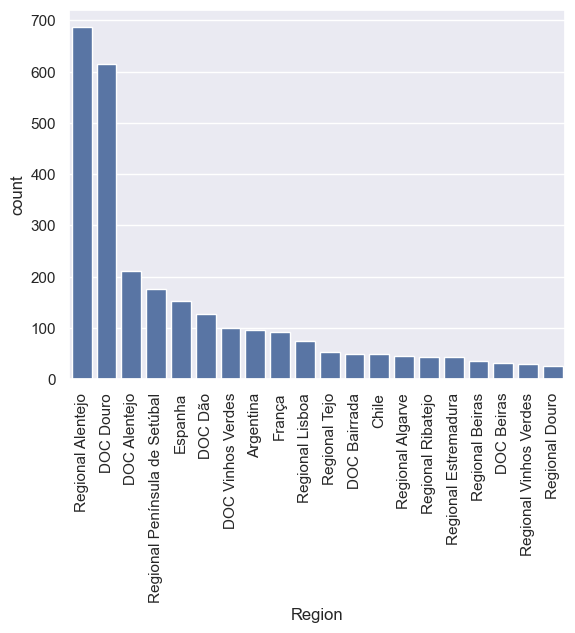

In [28]:
sns.countplot(x="Region",data=df,order=df.Region.value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.show()

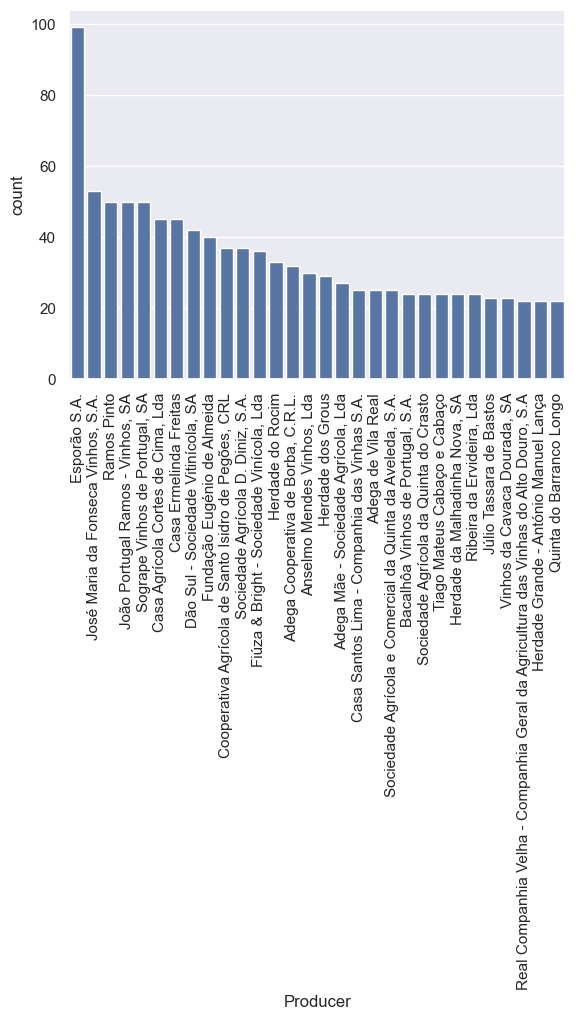

In [29]:
sns.countplot(x="Producer",data=df,order=df.Producer.value_counts().iloc[:30].index)
plt.xticks(rotation=90)
plt.show()

In [30]:
df.to_csv('..\\data\\processed\\data_transformed.csv')

___________________________________________________________________________________________

# Clustering


Clustering is used here as an exploratory tool rather than a discovery of well-defined wine categories.  
Given the subjective nature of the target ratings and the absence of chemical or sensory measurements, strong natural groupings are not guaranteed to exist.

The purpose of clustering in this notebook is to examine whether the available features induce any meaningful structure in the data, and to compare how different feature subsets (numerical attributes versus categorical descriptors such as grape varieties) affect the resulting group separation.  

This step helps assess whether the dataset contains intrinsic patterns beyond simple price- or age-based stratification, or whether apparent structure is largely driven by a small number of dominant numerical variables.

### Clustering - numerical features

In [31]:
df["avg_price"] = (df["MinimunPrice"] + df["MaximumPrice"]) / 2
df["log_avg_price"] = np.log1p(df["avg_price"])
features_num = ["AlcoholPercentage", "log_avg_price", "Age", "JudgeRating"]

X_num = df[features_num].copy()


for c in features_num:
    X_num[c] = pd.to_numeric(X_num[c], errors="coerce")

X_num = X_num.dropna()
X_num = X_num[(X_num["log_avg_price"] >= 0)]
X_num = X_num[(X_num["AlcoholPercentage"] > 0) & (X_num["AlcoholPercentage"] < 30)]


X_num = X_num.replace([np.inf, -np.inf], np.nan).dropna()

np.isinf(X_num.to_numpy()).sum(), np.isnan(X_num.to_numpy()).sum(), X_num.shape


(np.int64(0), np.int64(0), (2980, 4))

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

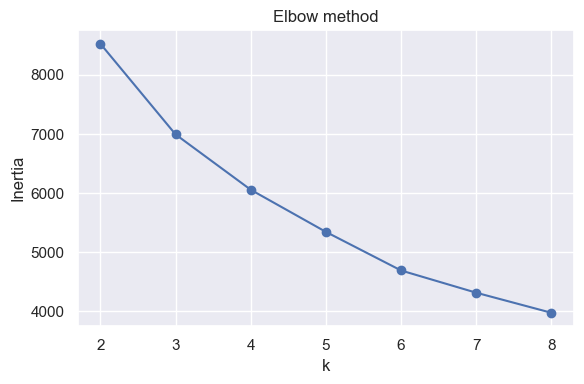

In [33]:
#Using the elbow method to find the optimal number of clusters
inertia = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertia, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.tight_layout()
plt.show()

In [34]:
#From the plot, k=3 looks like a good choice
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

labels = kmeans.fit_predict(X_scaled)

df.loc[X_num.index, "cluster"] = labels

df["cluster"].value_counts().sort_index()

cluster
0.0     738
1.0    1195
2.0    1047
Name: count, dtype: int64

In [35]:
#Let's see the cluster centers in original scale
cluster_summary = (
    df.loc[X_num.index]
    .groupby("cluster")[features_num]
    .mean()
    .round(2)
)

cluster_summary

,AlcoholPercentage,log_avg_price,Age,JudgeRating
cluster,,,,
0.0,13.17,1.88,21.34,14.66
1.0,14.05,2.84,17.81,16.40
2.0,12.88,2.13,13.06,15.49


Let's take a look at the destributions of features by clusters

In [36]:
#Let's see the grape varieties by cluster
grape_by_cluster = (
    df.groupby("cluster")[castes_ohe.columns]
    .mean()
)

grape_by_cluster.head()

,alfrocheiro,alfrocheiro e alicante bouschet,alfrocheiro e aragonez,alfrocheiro e cabernet sauvignon,alfrocheiro e jaen,alfrocheiro e rufete,alfrocheiro e syrah,alfrocheiro e tinta roriz,alfrocheiro e touriga nacional,alfrocheiro e trincadeira,...,viosinho e viognier,viozinho,vital e vinhas velhas,viura,welschriesling e chardonnay,xarello,xarello e parellada,zeta,zinfandel,zinfandel e petit syrah
cluster,,,,,,,,,,,,,,,,,,,,,
0.0,0.014905,0.001355,0.001355,0.001355,0.005420,0.001355,0.001355,0.012195,0.000000,0.000000,...,0.000000,0.001355,0.000000,0.00000,0.000000,0.001355,0.000000,0.000000,0.000000,0.000000
1.0,0.008368,0.005021,0.000837,0.001674,0.001674,0.000000,0.000000,0.002510,0.000000,0.001674,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000837,0.000000,0.000000,0.003347,0.000837
2.0,0.000955,0.000000,0.000955,0.000000,0.000955,0.000000,0.000000,0.002865,0.000955,0.000000,...,0.000955,0.000000,0.000955,0.00191,0.000955,0.000955,0.000955,0.000955,0.000000,0.000000


In [37]:
top_grapes_per_cluster = {
    c: grape_by_cluster.loc[c].sort_values(ascending=False).head(10)
    for c in grape_by_cluster.index
}

top_grapes_per_cluster

{0.0: touriga nacional                  0.151762
 trincadeira                       0.105691
 aragonez                          0.102981
 tinta roriz                       0.082656
 aragones                          0.075881
 touriga franca                    0.058266
 cabernet sauvignon                0.056911
 castelao                          0.052846
 syrah                             0.031165
 touriga franca e tinta barroca    0.028455
 Name: 0.0, dtype: float64,
 1.0: touriga nacional      0.217573
 syrah                 0.090377
 alicante bouschet     0.081172
 touriga franca        0.075314
 tinta roriz           0.075314
 aragonez              0.065272
 trincadeira           0.064435
 vinhas velhas         0.044351
 cabernet sauvignon    0.039331
 aragones              0.035983
 Name: 1.0, dtype: float64,
 2.0: touriga nacional    0.098376
 arinto              0.076409
 antao vaz           0.076409
 alvarinho           0.069723
 viosinho            0.053486
 aragonez          

In [38]:
#Visualize the top grape varieties by cluster
region_by_cluster = (
    df.groupby("cluster")["Region"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

region_by_cluster.head()

Region,Alemanha,Argentina,Austrália,Brasil,Chile,DOC Alentejo,DOC Algarve,DOC Bairrada,DOC Beiras,DOC Douro,...,Regional Península de Setúbal,Regional Ribatejo,Regional Tejo,Regional Trás-os-Montes,Regional Vinhos Verdes,Suiça,Tunísia,Uruguai,África do Sul,Áustria
cluster,,,,,,,,,,,,,,,,,,,,,
0.0,0.005427,0.025780,0.004071,0.000000,0.014925,0.069199,0.000000,0.016282,0.009498,0.195387,...,0.065129,0.040706,0.012212,0.002714,0.002714,0.000000,0.001357,0.001357,0.005427,0.004071
1.0,0.000000,0.054484,0.002515,0.000000,0.015926,0.085499,0.000000,0.015926,0.005029,0.233026,...,0.050293,0.010897,0.010059,0.000838,0.001676,0.000000,0.000000,0.001676,0.007544,0.000000
2.0,0.013384,0.010516,0.003824,0.001912,0.018164,0.055449,0.000956,0.018164,0.018164,0.185468,...,0.065010,0.000956,0.030593,0.000956,0.023901,0.000956,0.000000,0.000956,0.002868,0.002868


In [39]:
# Visualize the color distribution by cluster
color_by_cluster = (
    df.groupby("cluster")["Color"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

color_by_cluster

Color,Red,Rosé,White
cluster,,,
0.0,0.720867,0.071816,0.207317
1.0,0.809205,0.003347,0.187448
2.0,0.212034,0.085960,0.702006


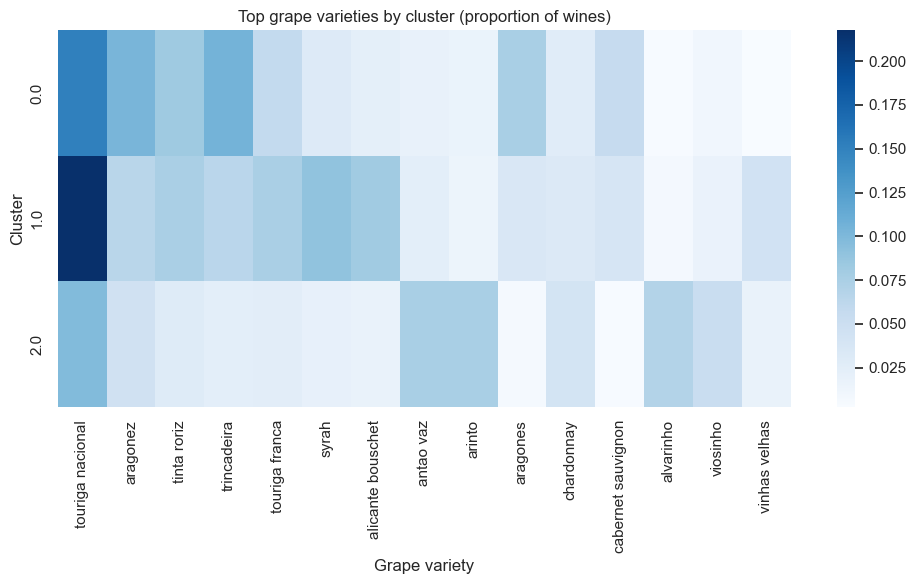

In [40]:
top_grapes = castes_ohe.sum().sort_values(ascending=False).head(15).index

grape_by_cluster = (
    df.groupby("cluster")[top_grapes]
    .mean()
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    grape_by_cluster,
    cmap="Blues"
)
plt.title("Top grape varieties by cluster (proportion of wines)")
plt.ylabel("Cluster")
plt.xlabel("Grape variety")
plt.tight_layout()
plt.show()

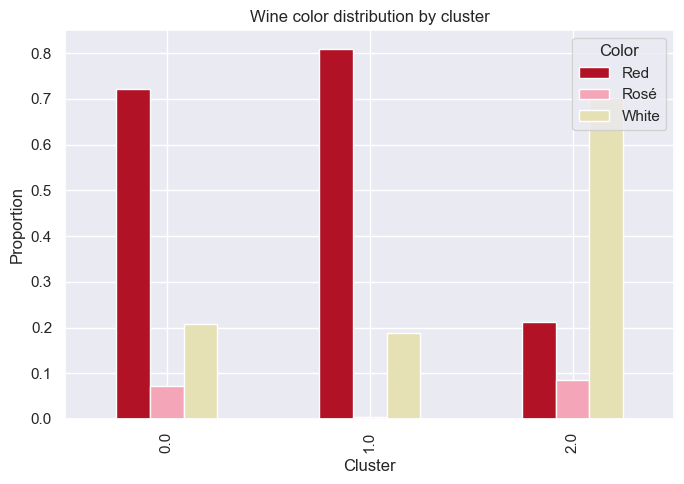

In [41]:
# Visualize the color distribution by cluster
color_map = {
    "Red": "#b11226",     # deep red
    "Rosé": "#f4a6b8",    # rosé pink
    "White": "#e6e1b5"   # light cream / white
}

color_by_cluster.plot(
    kind="bar",
    figsize=(7, 5),
    color=[color_map.get(c, "#999999") for c in color_by_cluster.columns]
)

plt.title("Wine color distribution by cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title="Color")
plt.tight_layout()
plt.show()

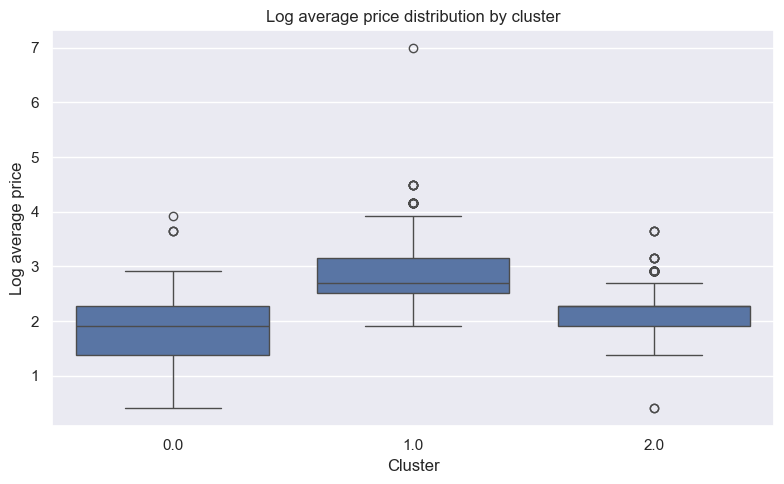

In [42]:
# Let's see the distribution of average price by cluster
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="cluster",
    y="log_avg_price",
    data=df.loc[X_num.index]
)
plt.title("Log average price distribution by cluster")
plt.xlabel("Cluster")
plt.ylabel("Log average price")
plt.tight_layout()
plt.show()

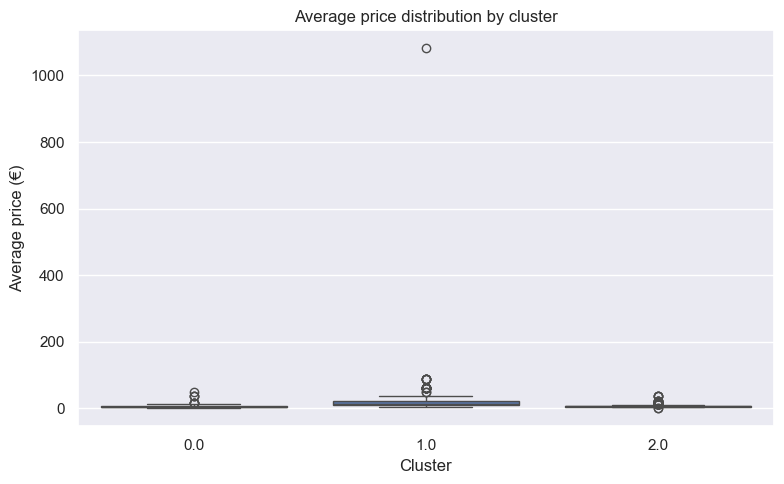

In [43]:
plt.figure(figsize=(8, 5))

sns.boxplot(
    x="cluster",
    y=np.expm1(df.loc[X_num.index, "log_avg_price"]),
    data=df.loc[X_num.index]
)

plt.title("Average price distribution by cluster")
plt.xlabel("Cluster")
plt.ylabel("Average price (€)")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Average price (€)')

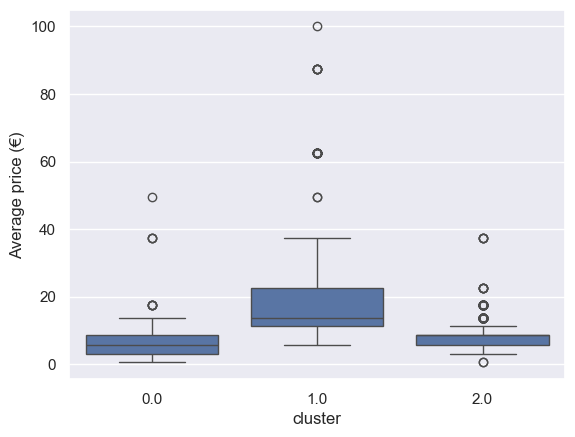

In [44]:
price_plot = df.loc[X_num.index, "avg_price"].clip(upper=100)

sns.boxplot(
    x="cluster",
    y=price_plot,
    data=df.loc[X_num.index]
)
plt.ylabel("Average price (€)")

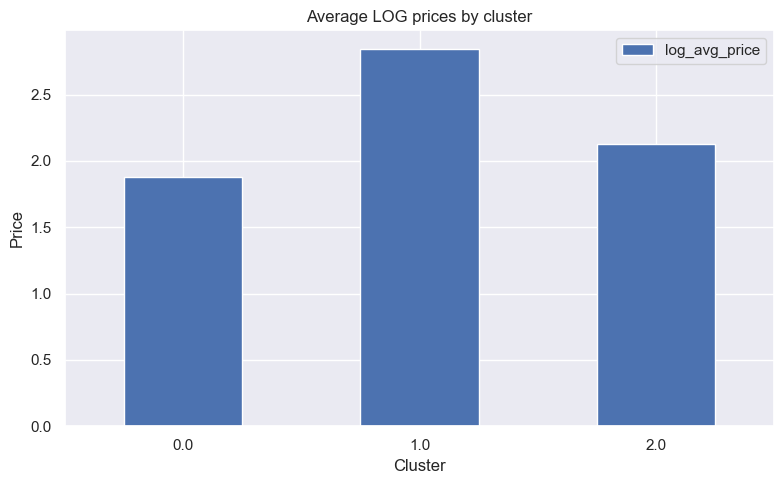

In [45]:
price_summary = (
    df.loc[X_num.index]
    .groupby("cluster")[["log_avg_price"]]
    .mean()
)

price_summary.plot(
    kind="bar",
    figsize=(8, 5)
)

plt.title("Average LOG prices by cluster")
plt.ylabel("Price")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


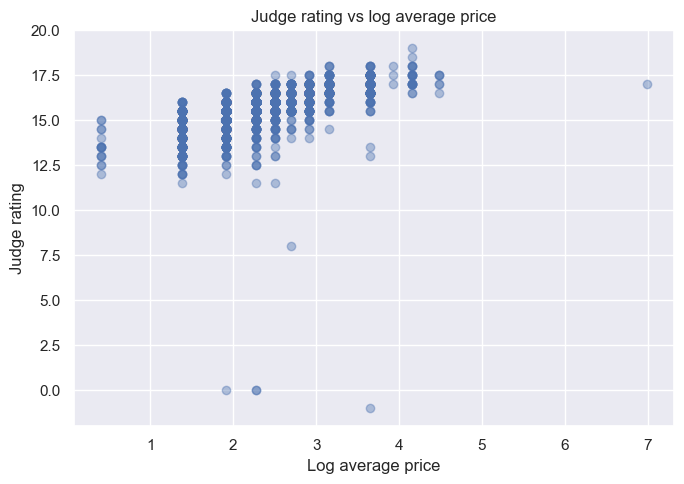

In [46]:
plt.figure(figsize=(7, 5))
plt.scatter(
    df.loc[X_num.index, "log_avg_price"],
    df.loc[X_num.index, "JudgeRating"],
    alpha=0.4
)

plt.xlabel("Log average price")
plt.ylabel("Judge rating")
plt.title("Judge rating vs log average price")
plt.tight_layout()
plt.show()

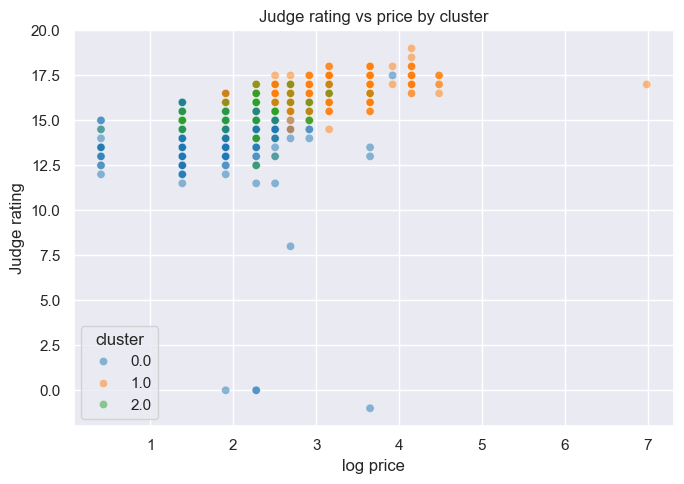

In [47]:
# Visualize Judge rating vs LOG price by cluster
sns.set_palette("Set2") 
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=np.log1p(df.loc[X_num.index, "avg_price"]),
    y=df.loc[X_num.index, "JudgeRating"],
    hue=df.loc[X_num.index, "cluster"],
    palette="tab10",
    alpha=0.5
)
plt.xlabel("log price")
plt.ylabel("Judge rating")
plt.title("Judge rating vs price by cluster")
plt.tight_layout()
plt.show()


### Clustering - non_numerical features

In [48]:
# Clustering by grape varieties
# build X_grapes with the same index as df
X_grapes = castes_ohe.loc[df.index]          
X_grapes = X_grapes.loc[:, X_grapes.sum() >= 50]

Xg_scaled = StandardScaler().fit_transform(X_grapes)

kmeans_grapes = KMeans(n_clusters=3, random_state=42, n_init=10)
df.loc[X_grapes.index, "grape_cluster"] = kmeans_grapes.fit_predict(Xg_scaled)


In [49]:
# Alternative approach without aligning indices 
X_grapes = castes_ohe.loc[:, castes_ohe.sum() >= 50]
Xg_scaled = StandardScaler().fit_transform(X_grapes)

kmeans_grapes = KMeans(n_clusters=3, random_state=42, n_init=10)
df["grape_cluster"] = kmeans_grapes.fit_predict(Xg_scaled)

In [50]:
#Let's see the cluster centers in original scale
df.groupby("grape_cluster")["Region"].value_counts(normalize=True)


grape_cluster  Region                       
0              Regional Alentejo                0.219235
               DOC Douro                        0.179477
               DOC Alentejo                     0.060583
               Regional Península de Setúbal    0.060204
               Espanha                          0.057933
                                                  ...   
2              Suiça                            0.000000
               Tunísia                          0.000000
               Uruguai                          0.000000
               África do Sul                    0.000000
               Áustria                          0.000000
Name: proportion, Length: 177, dtype: float64

In [51]:
#Let's see the cluster centers in original scale
df.groupby("grape_cluster")[["MinimunPrice", "MaximumPrice",'Age','AlcoholPercentage',"JudgeRating"]].mean()


,MinimunPrice,MaximumPrice,Age,AlcoholPercentage,JudgeRating
grape_cluster,,,,,
0,9.562382,14.703214,16.716824,13.372401,15.640076
1,12.880503,16.720126,18.830189,13.679245,15.896226
2,8.717514,13.352542,19.875706,13.810734,15.542373


The most noticable difference - is price 

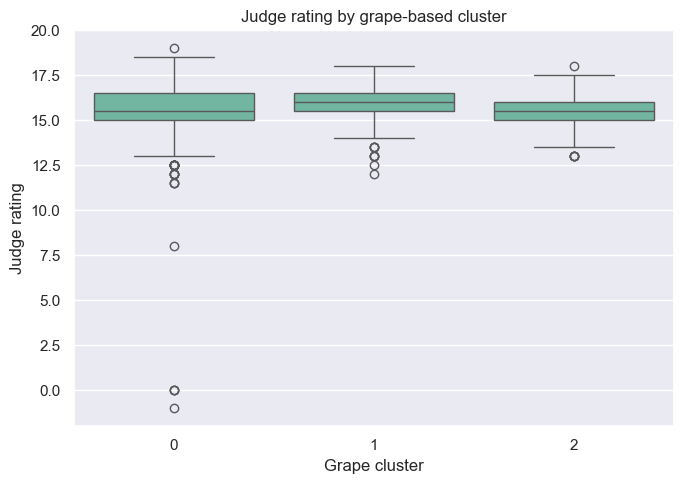

In [52]:
# plt boxplot of Judge rating by grape-based cluster
plt.figure(figsize=(7, 5))
sns.boxplot(
    x="grape_cluster",
    y="JudgeRating",
    data=df
)
plt.title("Judge rating by grape-based cluster")
plt.xlabel("Grape cluster")
plt.ylabel("Judge rating")
plt.tight_layout()
plt.show()


In [53]:
# Cross-tabulation of original clusters vs grape-based clusters
pd.crosstab(
    df["cluster"],
    df["grape_cluster"],
    normalize="index"
)

grape_cluster,0,1,2
cluster,,,
0.0,0.836043,0.058266,0.105691
1.0,0.863598,0.074477,0.061925
2.0,0.950334,0.025788,0.023878


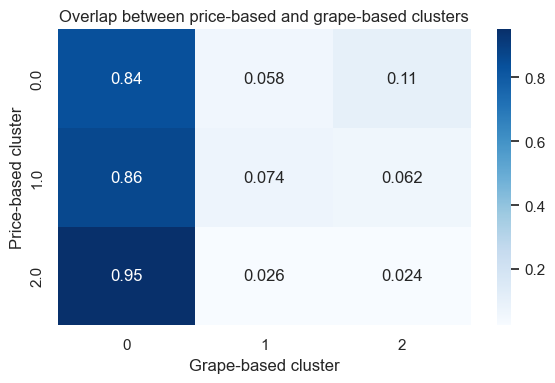

In [54]:
# Heatmap of the cross-tabulation
overlap = pd.crosstab(
    df["cluster"],
    df["grape_cluster"],
    normalize="index"
)

plt.figure(figsize=(6, 4))
sns.heatmap(overlap, annot=True, cmap="Blues")
plt.title("Overlap between price-based and grape-based clusters")
plt.xlabel("Grape-based cluster")
plt.ylabel("Price-based cluster")
plt.tight_layout()
plt.show()


The overlap matrix shows that price-based clusters almost entirely map to a single grape-based cluster, with proportions ranging from 84% to 95%. The remaining grape-based clusters capture only a small fraction of observations across all price-driven groups.

This indicates that grape-based clustering does not introduce an independent or complementary structure. Instead, it collapses most wines into one dominant cluster, failing to differentiate wines that are clearly separated when using numerical features such as price, age, and alcohol content.

In other words, clusters obtained from grape information do not align with meaningful distinctions in the data and do not explain the variability captured by price-based clustering. This suggests that grape composition, as represented in this dataset, carries little discriminative signal for subjective wine ratings.


------------

# Modelling

Next, we try to predict the judges’ rating directly. The point here is not to build a production-ready model, but to see how different types of information behave when we actually ask a model to use them.

We train three models — linear regression, random forest, and gradient boosting — mainly to cover increasing levels of complexity. Linear regression serves as a simple baseline, while tree-based models allow for non-linear effects and interactions.

Each model is trained on three versions of the data: numerical features only (price, age, alcohol), categorical information only (grapes, region, producer), and the full feature set. Comparing these setups helps answer a simple question: does adding more descriptive data really help, or does it just add noise? Based on the results, we then look at model explainability to understand what actually drives the predictions.


In [55]:
# Let's prepare data for predictive modeling
y = df["JudgeRating"]
X_num = df[
    ["AlcoholPercentage", "log_avg_price","Age"]
].copy()
region_ohe = pd.get_dummies(df["Region"], prefix="region")
color_ohe = pd.get_dummies(df["Color"], prefix="color")
X_comp = pd.concat(
    [castes_ohe, region_ohe, color_ohe],
    axis=1
)
X_all = pd.concat(
    [X_num, X_comp],
    axis=1
)

In [56]:
# Split the data into training and testing sets
Xn_train, Xn_test, y_train, y_test = train_test_split(
    X_num, y, test_size=0.25, random_state=42
)

Xc_train, Xc_test, _, _ = train_test_split(
    X_comp, y, test_size=0.25, random_state=42
)

Xa_train, Xa_test, _, _ = train_test_split(
    X_all, y, test_size=0.25, random_state=42
)
Xn_train.shape, Xc_train.shape, Xa_train.shape


((2235, 3), (2235, 783), (2235, 786))

In [57]:
# Define models to evaluate
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        random_state=42
    )
}

In [58]:
# Function to train and evaluate a model
def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, pred),
        "R2": r2_score(y_test, pred)
    }

In [59]:
# Evaluate models with different feature sets
results = []

for model_name, model in models.items():
    # Numerical only
    res_num = evaluate(model, Xn_train, Xn_test, y_train, y_test)
    results.append({
        "Features": "Numerical",
        "Model": model_name,
        **res_num
    })

    # Composition only (grapes + region + color)
    res_comp = evaluate(model, Xc_train, Xc_test, y_train, y_test)
    results.append({
        "Features": "Composition",
        "Model": model_name,
        **res_comp
    })

    # All features
    res_all = evaluate(model, Xa_train, Xa_test, y_train, y_test)
    results.append({
        "Features": "All",
        "Model": model_name,
        **res_all
    })

results_df = pd.DataFrame(results)
results_df


,Features,Model,MAE,R2
0,Numerical,LinearRegression,0.447298,0.605476
1,Composition,LinearRegression,0.727653,-0.108998
2,All,LinearRegression,0.540911,0.302793
3,Numerical,RandomForest,0.504906,0.320528
4,Composition,RandomForest,0.680393,0.015369
5,All,RandomForest,0.473732,0.308450
6,Numerical,GradientBoosting,0.451568,0.575811
7,Composition,GradientBoosting,0.703111,0.042605
8,All,GradientBoosting,0.453527,0.352772


Looking at the results, a few patterns are immediately clear. Models trained on numerical features consistently perform better than those relying on composition alone. Using only grapes, region, and producer leads to very weak performance, and in the linear model the R² even becomes negative, meaning the model performs worse than a simple average prediction.

Adding categorical information to numerical features does not improve results in a meaningful way. In most cases, performance either stays similar or slightly degrades compared to numerical-only models. This holds across all model types, including non-linear ones.

Model complexity also does not change the overall picture. Tree-based models do not recover useful signal from composition features, suggesting that the limitation comes from the data itself rather than from the choice of model.

Overall, these results support the idea already hinted at by the exploratory analysis and clustering: price, age, and alcohol carry most of the usable information for predicting subjective wine ratings, while categorical descriptors mainly add noise.


---------------

# Explainability

Based on the results above, we focus the explainability analysis on models trained using numerical features only. Among them, Gradient Boosting achieves strong performance while allowing for non-linear relationships, and Linear Regression provides a simple and transparent baseline.

These two models represent complementary perspectives: one captures more complex patterns, while the other remains easy to interpret. Applying SHAP to both allows us to check whether feature importance is consistent across model types and to better understand how price, age, and alcohol influence individual predictions.

In the next section, we use SHAP to explore both global and local explanations for these models.


In [60]:
rng = np.random.RandomState(42)
sample_idx = rng.choice(Xn_test.index, size=3, replace=False)
Xn_sample = Xn_test.loc[sample_idx]

sample_idx

array([1240, 2440,  204])

### Linear regression with Shap

In [61]:
lin_model = LinearRegression()
lin_model.fit(Xn_train, y_train)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(Xn_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

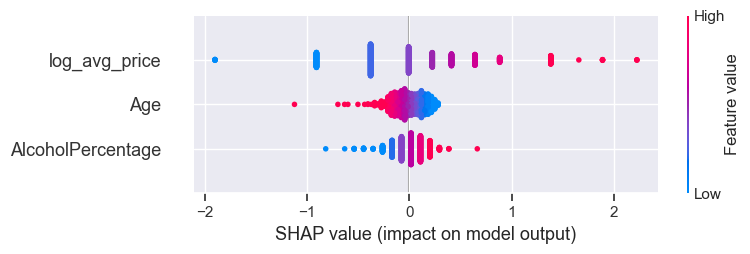

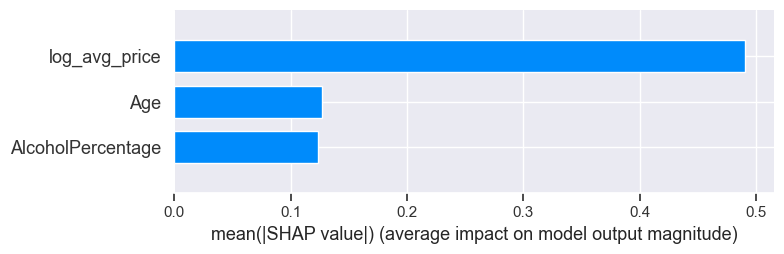

In [62]:
explainer_lin = shap.LinearExplainer(lin_model, Xn_train)
shap_values_lin = explainer_lin(Xn_test)

shap.summary_plot(shap_values_lin, Xn_test, show=True)          # beeswarm
shap.summary_plot(shap_values_lin, Xn_test, plot_type="bar")    # bar

The SHAP results make the picture very clear. Price is by far the dominant driver of the model’s predictions. Higher prices consistently push the predicted rating up, while lower prices pull it down, and the magnitude of this effect is much larger than for any other feature.

Age and alcohol percentage do have an influence, but it is noticeably smaller and more localized around zero. Older wines tend to slightly increase the predicted rating, while alcohol percentage shows a weaker and less consistent effect.

Overall, both the global importance plot and the SHAP value distribution confirm what we saw earlier in the analysis: most of the predictive signal comes from price, with age and alcohol playing secondary roles. The model


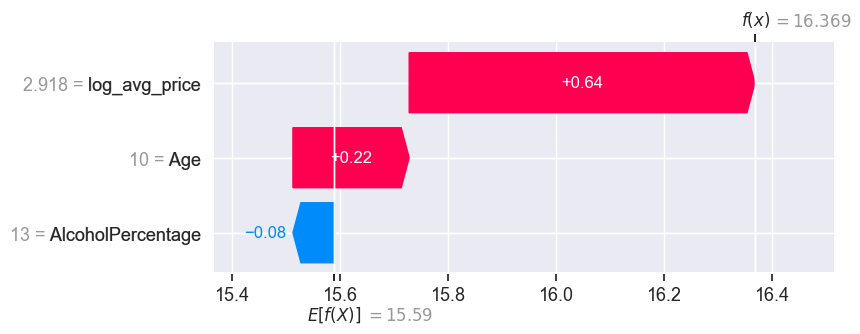

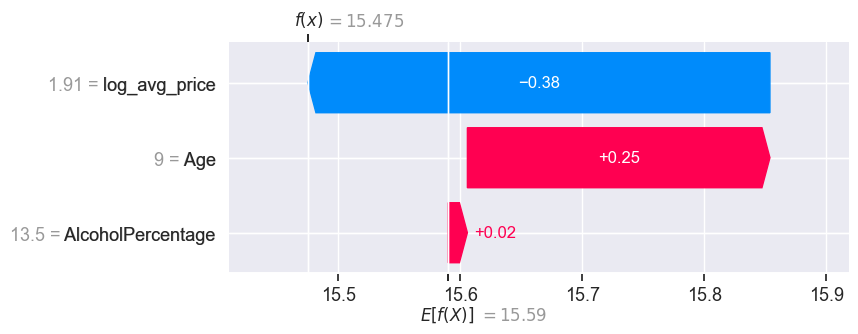

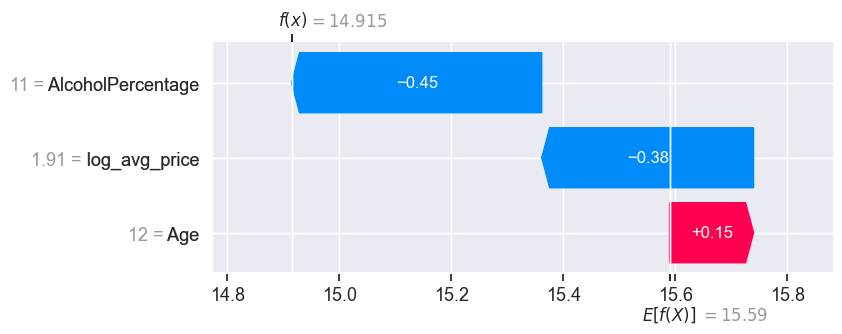

In [63]:
for idx in sample_idx:
    i = Xn_test.index.get_loc(idx)
    shap.plots.waterfall(shap_values_lin[i], max_display=10)

The local explanations tell the same story, but at the level of individual wines. In each example, the prediction starts from the average rating and is then pushed up or down mainly by price.

For the first wine, a relatively high price strongly increases the predicted rating, while age adds a smaller positive contribution and alcohol slightly pulls the prediction down. In the second case, a lower price pushes the prediction below the average, partially compensated by age. In the third example, both price and alcohol contribute negatively, and age is not enough to offset their effect.

Across all three cases, the pattern is consistent: price dominates the direction and magnitude of the prediction, while age and alcohol act as secondary adjustments. The model is not relying on complex interactions, but rather applying


### Gradient Boosting with Shap

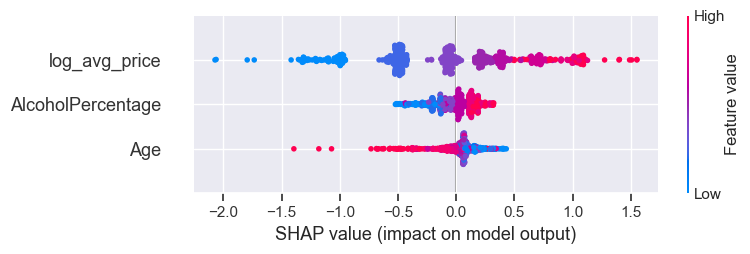

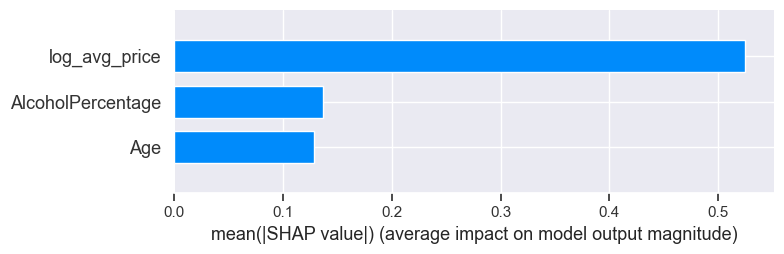

In [64]:
explainer_gb = shap.TreeExplainer(gb_model)
shap_values_gb = explainer_gb(Xn_test)

shap.summary_plot(shap_values_gb, Xn_test, show=True)           # beeswarm
shap.summary_plot(shap_values_gb, Xn_test, plot_type="bar")     # bar

The Gradient Boosting SHAP results closely mirror what we observed with the linear model. Price remains the dominant factor by a large margin: higher prices consistently push predictions up, while lower prices pull them down, and the spread of SHAP values is much wider than for the other features.

Alcohol percentage has a moderate effect, mostly positive at higher values, but its influence is clearly secondary. Age shows the weakest and least consistent contribution, with SHAP values concentrated close to zero for most observations.

The fact that a more flexible, non-linear model produces essentially the same feature importance ranking suggests that this pattern is not an artifact of model choice. Instead, it reflects the underlying structure of the data: the model is learning a simple relationship driven primarily by price, with alcohol and age acting as minor adjustments rather than key drivers.


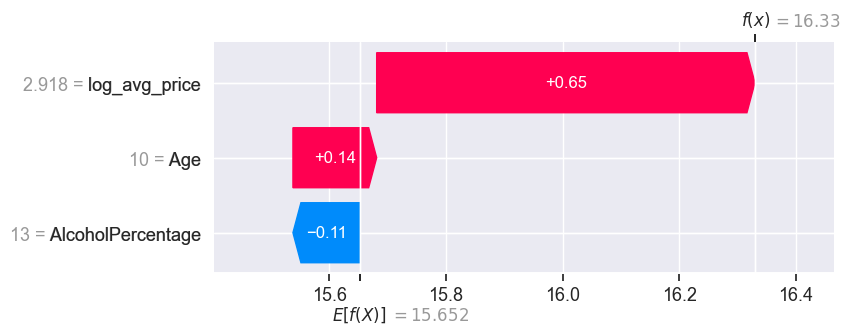

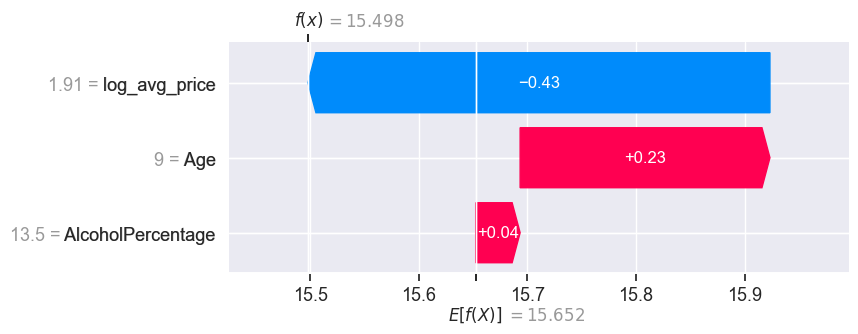

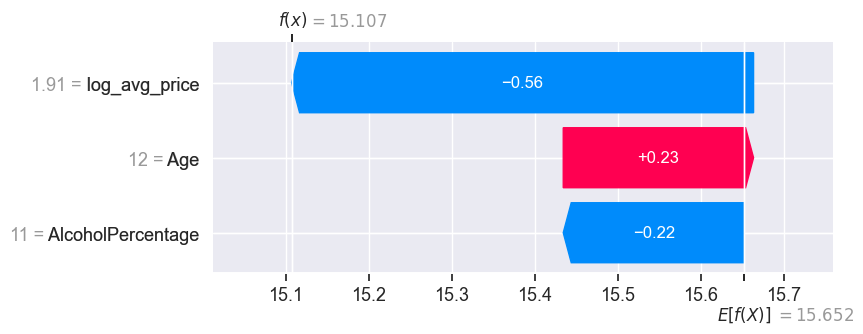

In [65]:
for idx in sample_idx:
    i = Xn_test.index.get_loc(idx)
    shap.plots.waterfall(shap_values_gb[i], max_display=10)

The local explanations for the Gradient Boosting model follow the same pattern as before. In all three examples, price is the main factor determining whether the prediction ends up above or below the average rating.

For the first wine, a high price strongly pushes the prediction upward, while age adds a small positive contribution and alcohol slightly reduces the final value. In the second case, a lower price pulls the prediction down, partially offset by age and alcohol. In the third example, both price and alcohol contribute negatively, and age again provides only a modest correction.

Across individual predictions, the model applies a consistent logic: price sets the direction and scale of the prediction, while age and alcohol make relatively small adjustments. Even with a more flexible model, there is no evidence of complex or unexpected interactions driving the results.


---------

## Overall Conclusion

This analysis explored a dataset of Portuguese wines with subjective ratings, using exploratory analysis, clustering, predictive modeling, and explainability. Across all steps, a consistent picture emerged.

Numerical features — particularly price — carry most of the usable signal in the data. Age and alcohol percentage play secondary roles, while categorical descriptors such as grape varieties, region, and producer do not introduce meaningful structure. Clustering based on composition fails to produce interpretable groups, and predictive models trained on these features perform poorly, even when using non-linear methods.

Predictive modeling and SHAP explainability confirm that model behavior is driven by a small number of dominant variables rather than by complex interactions. More expressive models do not uncover hidden patterns, suggesting that the limitation lies in the information content of the dataset rather than in the modeling approach.

Overall, this notebook illustrates an important practical lesson: adding more features does not necessarily lead to better insights. When targets are subjective and key explanatory variables are missing, even well-applied methods may converge on simple, perception-driven relationships. Recognizing these limits is as important as extracting patterns when they exist.
